In [137]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [138]:
print(train_data.shape)
print(np.mean(train_data))
print(np.mean(train_targets))

(404, 13)
69.79277358530084
22.395049504950492


In [139]:
print(test_data.shape)
print(np.mean(test_data))
print(np.mean(test_targets))

(102, 13)
71.18771368778282
23.07843137254902


In [140]:
# Normalizing the data (feature-wise normalization)
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [141]:
# Model definition
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',\
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [142]:
# K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
        train_data[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [143]:
all_scores

[2.1865712864564197, 2.6296345621052355, 2.529456875111797, 2.4690135811815166]

In [144]:
np.mean(all_scores)

2.453669076213742

In [85]:
# Saving the validation logs at each fold

num_epochs = 80
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                       validation_data=(val_data, val_targets),
                       epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [135]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 88us/step


16.865432402666876

In [115]:
(np.mean(train_data) - np.mean(test_data))/500

-4.16539828611845e-05

In [86]:
# Building the history of sucessive mean K-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
print(average_mae_history)

[7.824782318407945, 6.335932518586073, 6.527779155438489, 5.805001418779392, 4.819045224992355, 5.7889755964279175, 5.289062080997052, 5.118465915174768, 5.062638522374748, 4.43528145256609, 5.258801797829053, 4.643323508819732, 4.362512065632508, 4.912214584869913, 4.430319257301859, 4.470691728119803, 4.493581346946187, 4.168083467105827, 4.707866128128354, 4.263521370321217, 4.1710542334188325, 4.099252239312276, 3.721382977938888, 4.112156746411087, 3.899229866443294, 3.6333327210775703, 3.7475886557361866, 3.6170278893839014, 3.8938442415530137, 4.005143679014527, 4.18738072697479, 3.8226884780543866, 3.7927535111361212, 3.7783372307767964, 3.6719018138281188, 3.6056280649534544, 3.488527322759723, 3.552487239979281, 3.603469456186389, 3.700136766575351, 3.068062631210478, 3.1750609921936945, 3.374789793892662, 3.4047218572975386, 3.531719044883652, 3.188483736302593, 3.0450358803909605, 3.0178670009764117, 3.4107427974738695, 3.312873990228861, 3.182382583618164, 3.23452022524163

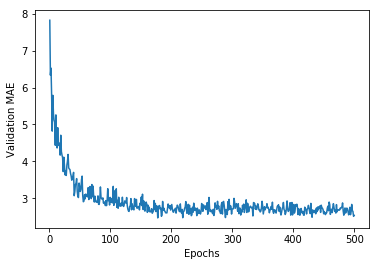

In [87]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

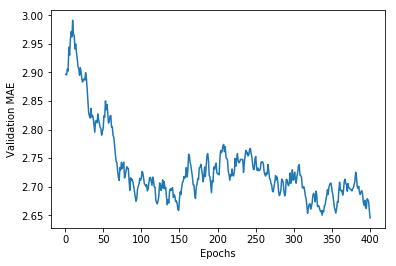

400


In [88]:
# Plotting validation scores, excluding the first 10 data points

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[100:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print(len(smooth_mae_history))

In [95]:
# Training the final model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation='relu',\
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
        train_data[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model()
    model.fit(train_data, train_targets,
             epochs=num_epochs, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
102/102 [==============================] - 0s 4ms/step


In [146]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 98us/step


2.8331969859553316